In [33]:
import numpy as np
from scipy.special import iv
from plasmapy.dispersion import plasma_dispersion_func as Z
from scipy.optimize import root
import matplotlib.pyplot as plt

In [34]:
def epsilon(w, k, T, theta, cVa):
    m=1
    e=1
    B=1
    m_max=6
    k_para = k*np.cos(theta*np.pi/180)
    k_perp = k*np.sin(theta*np.pi/180)
    w_ = complex(w[0], w[1])
    vth = np.sqrt(T/m)
    rho = m*vth/(e*B)
    W = e*B/m
    k_debye = cVa*(W/vth)**2
    l = (k_perp*rho)**2
    sum = 0
    for m in np.arange(-m_max, m_max+1, 1):
        z = (w_+m*W)/(np.sqrt(2)*np.abs(k_para)*vth)
        sum += iv(m, l)*Z(z)
    s_ = 1.0+w_*np.exp(-l)*sum/(np.sqrt(2)*np.abs(k_para)*vth)
    e_ = 1.0+s_*(k_debye/k)**2
    return [e_.real, e_.imag]

In [35]:
def solver(k, T, theta, cVa, x0):
    sol=root(epsilon, x0=x0, args=(k, T, theta, cVa), method='hybr') # hybr
    if sol.success != True :
        print('k : {:4.2f}  -  success : {} - x : {}'.format(k, sol.success, sol.x))
    return sol

In [36]:
def oneBranch(kk, x0, T, theta, cVa):
    ww=np.empty_like(kk, dtype=complex)
    for i, k in enumerate(kk):
        sol=solver(k, T, theta, cVa, x0=x0)
        ww[i]=complex(sol.x[0], sol.x[1])
        x0=sol.x
    return ww

In [37]:
kk=np.arange(7.8, 0.1, -0.1)
w1=oneBranch(kk=kk, x0=[0.5, -0.1], T=0.1, theta=85, cVa=100)
w2=oneBranch(kk=kk, x0=[1.5, -0.1], T=0.1, theta=85, cVa=100)
w3=oneBranch(kk=kk, x0=[2.5, -0.1], T=0.1, theta=85, cVa=100)
w4=oneBranch(kk=kk, x0=[3.5, -0.1], T=0.1, theta=85, cVa=100)

In [38]:
from pyphare.pharesee.hierarchy import get_times_from_h5
from scipy.fft import rfft2, rfftfreq
import os
from pyphare.pharesee.run import Run
from pyphare.pharesee.hierarchy import finest_field
import numpy as np
import matplotlib.pyplot as plt
#import h5py
run_path = "/home/smets/codeS/fAr/runs/bernstein/jobA/h5files"

In [39]:
file = os.path.join(run_path, "EM_B.h5")
times = get_times_from_h5(file)

In [40]:
r = Run(run_path)
#n, x = finest_field(r.GetNi(0), "rho")
n, x = finest_field(r.GetB(0), "Bz")

print("# of grid points : {}".format(n.shape[0]))
print("# of times : {}".format(times.shape[0]))

xt = np.empty([n.shape[0], times.shape[0]])

for it,t in enumerate(times):
    print("{:6d} / {:6d}".format(it, times.shape[0]))
    #n, x = finest_field(r.GetNi(t), "rho")
    n, x = finest_field(r.GetB(t), "Bz")
    xt[:,it] = n

# of grid points : 400
# of times : 400
     0 /    400
     1 /    400
     2 /    400
     3 /    400
     4 /    400
     5 /    400
     6 /    400
     7 /    400
     8 /    400
     9 /    400
    10 /    400
    11 /    400
    12 /    400
    13 /    400
    14 /    400
    15 /    400
    16 /    400
    17 /    400
    18 /    400
    19 /    400
    20 /    400
    21 /    400
    22 /    400
    23 /    400
    24 /    400
    25 /    400
    26 /    400
    27 /    400
    28 /    400
    29 /    400
    30 /    400
    31 /    400
    32 /    400
    33 /    400
    34 /    400
    35 /    400
    36 /    400
    37 /    400
    38 /    400
    39 /    400
    40 /    400
    41 /    400
    42 /    400
    43 /    400
    44 /    400
    45 /    400
    46 /    400
    47 /    400
    48 /    400
    49 /    400
    50 /    400
    51 /    400
    52 /    400
    53 /    400
    54 /    400
    55 /    400
    56 /    400
    57 /    400
    58 /    400
    59 /    400


In [41]:
def fourier(t, dx, dt):
    T = rfft2(t)
    k = 2*np.pi*rfftfreq(t.shape[0], d=dx)
    w = 2*np.pi*rfftfreq(t.shape[1], d=dt)
    return T[0:(t.shape[0]+1)//2,:], k, w

In [42]:
dt = 0.5
dx = 0.4
kw, k, w = fourier(xt, dx, dt)

In [43]:
print(kw.shape)
print(k.shape)
print(w.shape)

(200, 201)
(201,)
(201,)


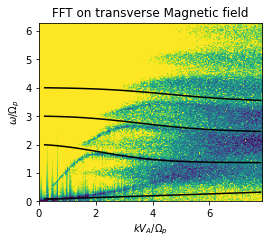

In [50]:
fig, ax = plt.subplots(figsize=(4,4))

#ax.imshow(np.transpose(np.abs(kw)), origin='lower', vmin=0, vmax=20, extent=[k[0],k[-1],w[0],w[-1]], cmap='viridis_r')
ax.imshow(np.transpose(np.log(np.abs(kw))), origin='lower', vmin=0, vmax=4, extent=[k[0],k[-1],w[0],w[-1]], cmap='viridis_r')

ax.plot(kk, w1.real, c='k')
ax.plot(kk, w2.real, c='k')
ax.plot(kk, w3.real, c='k')
ax.plot(kk, w4.real, c='k')

plt.xlabel("$k V_A/\Omega_p$")
plt.ylabel("$\omega / \Omega_p$")
#plt.title('FFT on longitudinal Electric field')
plt.title('FFT on transverse Magnetic field')
fig.savefig("bernstein.pdf", bbox_inches='tight')